In [1]:
"""
    Copyright (c) 2021 Olivier Leblanc

    Permission is hereby granted, free of charge, to any person obtaining
    a copy of this software and associated documentation files (the "Software"),
    to deal in the Software without restriction, including without limitation
    the rights to use, copy, modify, merge, publish, distribute, and to permit
    persons to whom the Software is furnished to do so.
    However, anyone intending to sublicense and/or sell copies of the Software
    will require the official permission of the author.
    ----------------------------------------------------------------------------

    Author : Olivier Leblanc
    Date : 27/11/2021

    Code description :
    __________________
    Generates a random interferometric matrix F with properties :
        - for all i \in [Q], F_ii = cste => tr (F)=Q F_ii
        - F_ij = F*_ji for all i,j \in [Q]
    And reconstruct F from Rank-One Projections (ROPs) :
        - y = a*Fa 
    Where 'y' is a scalar value for each ROP and 'a' is one projection vector.
    Here, the 'a's are chosen to minimize the number of ROPs required for a perfect reconstruction in the noiseless case.

"""
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc

import sys, os
def updir(d, n):
  for _ in range(n):
    d = os.path.dirname(d)
  return d
sys.path.append(os.path.join(updir(os.getcwd(), 3),'utils'))
from graphics import set_plot_params, subplot_axs, labels, show_rec2D
set_plot_params() # Set the plot params

Creation of $\mathcal{F}\left[\overline{f}\right]$ matrix

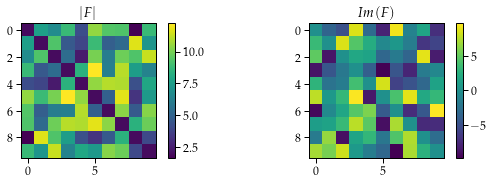

In [2]:
Q = 10

F = np.zeros((Q,Q), dtype=complex)
for i in range(Q):
    F[i,i]=2
    for j in range(i):
        F[i,j] = ((np.random.random(1) + np.random.random(1)*1j)-0.5-0.5j)*20
        F[j,i] = np.conj(F[i,j])

""" Plots """
fig = plt.figure(figsize=(8,2.8))
axs = subplot_axs(fig,1,2)
im1=axs[0].imshow(np.abs(F), cmap='viridis')
im2=axs[1].imshow(np.imag(F), cmap='viridis')
labels(axs[0], '$|F|$')
labels(axs[1], '$Im (F)$')
cb = fig.colorbar(im1, ax=axs[0])
cb2 = fig.colorbar(im2, ax=axs[1])
plt.show()

### Perfect reconstruction using $4Q(Q-1)+1$ ROPs in the noiseless case

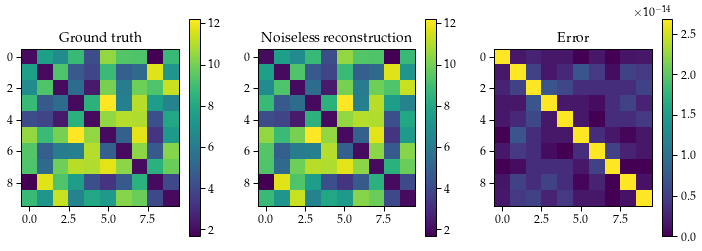

In [3]:
F_hat = np.zeros(F.shape, dtype=complex)
y = np.zeros(8, dtype=complex)

k = np.arange(4)
beta1 = np.exp(1j*np.pi*k/2)
beta2 = np.exp(1j*np.pi*(k+1)/2)
gamma = np.exp(-1j*np.pi*k/2)

"Fill off-diagonal"
for i in range(Q):
    for j in range(i+1,Q):
        # Generates 8 observations and combine appropriately
        a_ij = np.ones((Q,8), dtype=complex)
        a_ij[i,:4] = beta1
        a_ij[i,4:] = beta2
        a_ij[j,4:] = gamma
        a_ij[j,:4] = gamma
        a_ij_star = a_ij.conj().T
        for l in np.arange(8):
            y[l] = a_ij_star[l,:]@F@a_ij[:,l]
        F_hat[i,j] = (np.sum( (-1)**k*y[:4] ) + 1j*np.sum( (-1)**k*y[4:] ))/8
        F_hat[j,i] = F_hat[i,j].conj()


# Could be computed with "np.sum(F)"
a_ij = np.ones(Q)
sum_F = a_ij.T@F@a_ij
F_ii = 1/Q*(sum_F-np.sum(F_hat))

"Fill diagonal"
for i in range(Q):
    F_hat[i,i] = F_ii

show_rec2D(np.abs(F), np.abs(F_hat), show_error=True, prt_SNR=False)

### Perfect reconstruction using $Q(Q-1)+1$ ROPs if $|\alpha_i|$ is not fixed to 1

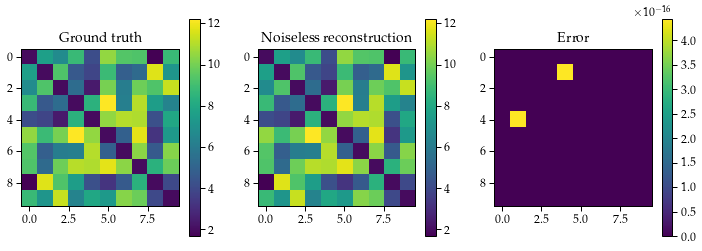

In [4]:
F_hat = np.zeros(F.shape, dtype=complex)
y = np.zeros(2, dtype=complex)

"Fill off-diagonal"
for i in range(Q):
    for j in range(i+1,Q):
        # Generates 8 observations and combine appropriately
        a_ij = np.zeros((Q,2), dtype=complex)
        a_ij[i,:] = 1
        a_ij[j,0] = 1
        a_ij[j,1] = -1j
        a_ij_star = a_ij.conj().T
        for l in np.arange(2):
            y[l] = a_ij_star[l,:]@F@a_ij[:,l]
        F_hat[i,j] = (y[0]+1j*y[1])
        F_hat[j,i] = F_hat[i,j].conj()

# Could be computed with "np.sum(F)"
a_ij = np.ones(Q, dtype=complex)
sum_F = a_ij.T@F@a_ij
F_ii = (np.sum(F_hat)-2*sum_F)/(2*Q*(Q-2))

for i in range(Q):
    F_hat[i,i] = F_ii

# Compensate for the 2F_mn+2(1+i)f^(0) term
for i in range(Q):
    for j in range(i+1,Q):
        # Generates 8 observations and combine appropriately
        F_hat[i,j] -= 2*(1+1j)*F_ii
        F_hat[i,j] = F_hat[i,j]/2
        F_hat[j,i] -= 2*(1-1j)*F_ii
        F_hat[j,i] = F_hat[j,i]/2

show_rec2D(np.abs(F), np.abs(F_hat), show_error=True, prt_SNR=False)

### Perfect reconstruction using $Q(Q-1)+1$ ROPs if $|\alpha_i| = c_i$ is imposed

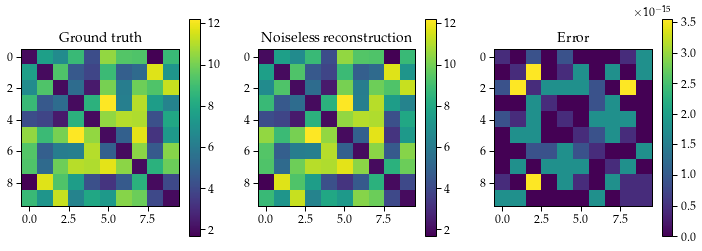

In [5]:
F_hat = np.zeros(F.shape, dtype=complex)
y = np.zeros(2, dtype=complex)
cqs = np.random.random(Q)
aqs_angles = np.ones(Q, dtype=complex)
aqs = cqs*aqs_angles

"Fill off-diagonal"
for i in range(Q):
    for j in range(i+1,Q):
        a_ij = np.zeros((2,2), dtype=complex)
        a_ij[0,0] = aqs[i]
        a_ij[0,1] = 1j*aqs[i]
        a_ij[1,:] = aqs[j]
        a_ij_star = a_ij.conj().T

        F2 = np.array([[F[i,i], F[i,j]],[F[j,i], F[j,j]]])
        for l in np.arange(2):
            y[l] = a_ij_star[l,:]@F2@a_ij[:,l]

        F_hat[i,j] = (y[0]+1j*y[1])
        F_hat[j,i] = F_hat[i,j].conj()

# Could be computed with "np.sum(F)"
sum_F = aqs.T@F@aqs
F_ii = (np.sum(F_hat)-2*sum_F)/(2*(Q-2)*np.sum(cqs**2))

F_hat += np.diag(F_ii*np.ones(F_hat.shape[0]))

# Compensate for the 2F_mn+2(1+i)f^(0) term
for i in range(Q):
    for j in range(i+1,Q):
        # Generates 8 observations and combine appropriately
        F_hat[i,j] -= (1+1j)*(cqs[i]**2+cqs[j]**2)*F_ii
        F_hat[i,j] = F_hat[i,j]/(2*aqs[i].conj()*aqs[j])
        F_hat[j,i] -= (1-1j)*(cqs[i]**2+cqs[j]**2)*F_ii
        F_hat[j,i] = F_hat[j,i]/(2*aqs[i]*aqs[j].conj())

show_rec2D(np.abs(F), np.abs(F_hat), show_error=True, prt_SNR=False)